<center> <h1> Lecture 8: Generative Adversarial Networks </h1> </center>
<center> Krishna Pillutla, Lang Liu, Zaid Harchaoui </center>
    <center> Data 598 (Winter 2022), University of Washington </center>

In this lecture, we will talk about deep generative models briefly and about generative adversarial networks (GANs) in particular. 
We will also utilize some additional features of PyTorch such as training on GPUs. 

The demo is based on [the D2L book](https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html).

See [this NYT article](https://www.nytimes.com/interactive/2020/11/21/science/artificial-intelligence-fake-people-faces.html) for some beautiful illustrations of the impressive capabilities of modern generative models.

# Generative Modeling

Consider an unknown data distribution $P$, for instance over images, text, or audio. We wish to generate synthetic samples from a distribution $Q \approx P$, such that it is easy to sample from $Q$. 

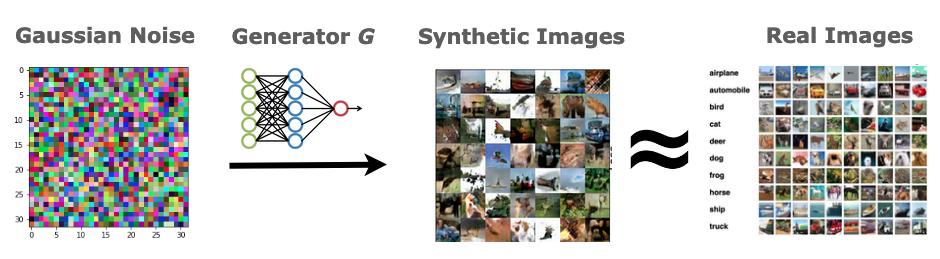

The general recipe of a generative model is to approximate it with a two-step procedure:
- sample $z \sim R$ from some simple distribution $R$ such as a Gaussian, and, 
- transform $z$ to $G(z)$ using a function $G(\cdot)$.


The distribution of $G(Z)$ for $Z \sim R$ is called the _pushforward distribution_ and is denoted as $G_\sharp R$. 

**Goal of generative modeling**: Find a map $G(\cdot)$ such that the distribution of $G(Z)$ for $Z \sim R$ is approximately equal to the data distribution $P$.

We parameterize the pushforward map $G(\cdot)$ using an expressive function class, such as a neural network. 

# Generative Adversarial Networks

The usual approach to write out the probability density function of the pushforward distribution $G_\sharp R$ (= the distribution of $G(Z)$ given $G\sim R$) quickly becomes difficult in high dimensions. GANs take an alternate approach of employing another neural network $D$ called the _discriminator_, whose job is to distinguish between real and synthetic data.

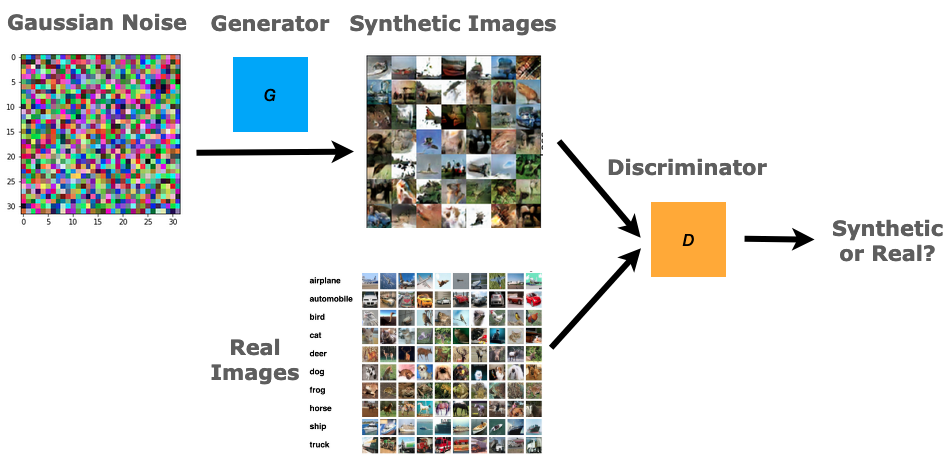

**Training**: The generator $G$ and discriminator $D$ are jointly trained with the goal of defeating each other. That is, the generator is incentivized to fool the discriminator and the discriminator is incentivized to get better at telling real data samples from synthetic ones. 

## Mathematical Details

We will parameterize the generator $G_\theta$ with a neural network with parameters $\theta$. Likewise, we will parameterize the discriminator $D_\varphi$ as a neural network with parameters $\varphi$. 
We assume that the output of $D_\varphi$ lies in $[0, 1]$, so that its output may be interpreted as a probability.

**Mixture Distribution**: At each step, we construct a binary classification problem as follows. The input data follows a mixture distribution of real and synthetic examples:
$$
    Q_\theta(x) = \frac{1}{2} \, \, \underbrace{P(x)}_{\text{real}} \,\, + \,\, \frac{1}{2} \,\, \underbrace{\Big([G_\theta]_\sharp R \Big)(x)}_{\text{synthetic}} \,.
$$
The correponding labels are $1$ if the data is real and $0$ if the data is synthetic:

**Discriminator Objective**: The discriminator is a binary classifier, such as logistic regression. Suppose that $D_\varphi(x)$ is the probability that $x$ is real. Then, the discriminators objective is to simply minimize the binary logistic loss $\ell$ of the data distribution $Q_\theta$ that we constructed, i.e., 
$$
    \min_\varphi  \left\{ \mathbb{E}_{(x, y) \sim Q_\theta} \left[\ell(y, D_\varphi(x)) \right] \right\}
\equiv     \min_\varphi  \left\{ \mathbb{E}_{(x, y) \sim Q_\theta}  \left[ - y \log D_\varphi(x) - (1-y) \log \left(1 - D_\varphi(x)\right)  \right] \right\} \,.
$$

Given the form of $Q_\theta$, we can further simplify this objective as 
$$
  \max_\varphi  \left\{ \mathbb{E}_{x \sim P} \left[ \log D_\varphi(x) \right]
                         + \mathbb{E}_{x' \sim [G_\theta]_\sharp R} \left[ \log \left(1 - D_\varphi(x') \right) \right] \right\}
\equiv   \\
  \max_\varphi  \left\{  \mathbb{E}_{x \sim P} \left[ \log D_\varphi(x) \right]
                         + \mathbb{E}_{z \sim R} \left[ \log \left(1 - D_\varphi(G_\theta(z)) \right) \right]       
                         \right\}
$$

**Generator Objective (Ideal)**: The objective of the generator is to maximize the logistic loss of the discriminator, i.e., 
$$
      \min_\theta  \left\{  \mathbb{E}_{x \sim P} \left[ \log D_\varphi(x) \right]
                         + \mathbb{E}_{z \sim R} \left[ \log \left(1 - D_\varphi(G_\theta(z)) \right) \right]       
                         \right\}
       \\ \equiv
       \min_\theta  \left\{  \mathbb{E}_{z \sim R} \left[ \log \left(1 - D_\varphi(G_\theta(z)) \right) \right]       
                         \right\}
$$

**Generator Objective (Proxy)**:
It turns out that this idealized objective is not well-conditioned for the generator, especially when the discriminator is good (where $D_\varphi(x') \approx 0$ for synthetic $x'$).

Since the goal of the generator is to fool the discriminator, its task is to get the discriminator to predict $D_\varphi(x') \approx 1$ for synthetic $x'$. Another objective that promotes this behavior is the 
$$
    \min_\theta \left\{ \mathbb{E}_{x' \sim [G_\theta]_\sharp R} \left[ \ell(1, D_\varphi(x')) \right] \right\}
    \\
    \equiv \min_\theta \left\{  
        \mathbb{E}_{z \sim R}\left[ 
            - \log\left( D_\varphi \circ G_\theta(z) \right)
        \right]
    \right\} \,.
$$


**Exercise**: Consider the sigmoidal parameterization $D_\varphi(x') = \big(1 + \exp(- s_\varphi(x')) \big)^{-1}$, where $s_\varphi$ is a neural network whose output can be real-valued (e.g., if the last layer is fully connected). 
- Compute the gradient of ideal generator objective as well as the proxy generator objective above w.r.t. the generator parameters $\theta$. 
- How do each of the gradients behave when $s_\varphi(x') \to - \infty$ for some synthetic $x'$? This corresponds to the case when the discriminator is perfect.  

In [1]:
import torch
import torchvision
import numpy as np

import time

import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings (Not a good idea in general, we use it under exceptional circumstances)
import warnings
warnings.filterwarnings("ignore")

# Data

We will generate images of Pokémon from the popular anime. 

**Download the data** from [this link](http://d2l-data.s3-accelerate.amazonaws.com/pokemon.zip) into `./data` and unzip it. 

**Details**: We use PyTorch utilities to store the datasets and dataloaders. 
A dataset object implements the `__getitem__` function, so that we can access its elements as `dataset[i]` 
for `i < len(dataset)`. 

The dataloader is an iterator so that iterating over the dataset amounts to running:
```
for data_batch in dataloader:
    # Process data_batch
```

In [2]:
batch_size = 256

data_dir = "./data/pokemon"

# Image preprocessing functions: resize and normalize mean/std
transform_function = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])

# Dataset object
pokemon_dataset = torchvision.datasets.ImageFolder(data_dir, transform=transform_function)

# Dataloader object
dataloader = torch.utils.data.DataLoader(
    pokemon_dataset, batch_size=batch_size,
    shuffle=True, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64]) 49


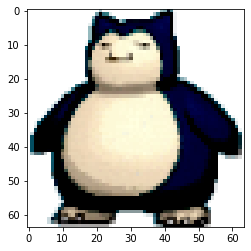

In [4]:
# access dataset items
x, y = pokemon_dataset[2954]
print(x.shape, y)
plt.imshow(x.permute(1, 2, 0))

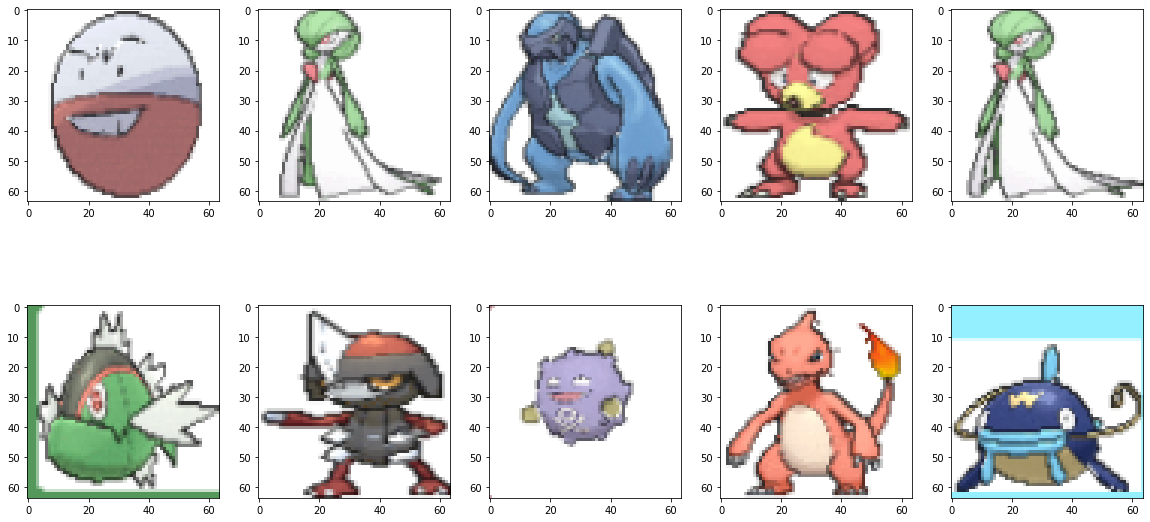

In [5]:
# Use dataloader in a loop
for X, y in dataloader:
    break
    
# Un-normalize
imgs = X[0:10,:,:,:]/2+0.5  

# Visualize
f, ax = plt.subplots(2, 5, figsize=(20, 10))
ax = ax.flatten()
for i in range(10):
    ax[i].imshow(imgs[i].permute(1, 2, 0))
    

# Model 

We will build our generator and discriminator to be (approximately) mirror images of each other, similar to autoencoders. 
- Discriminator: We will use a convolutional neural network.
- Generator: We will use a network with ConvTranspose layers, similar to the case of autoencoders.



**Autoencoder**: 

<div>
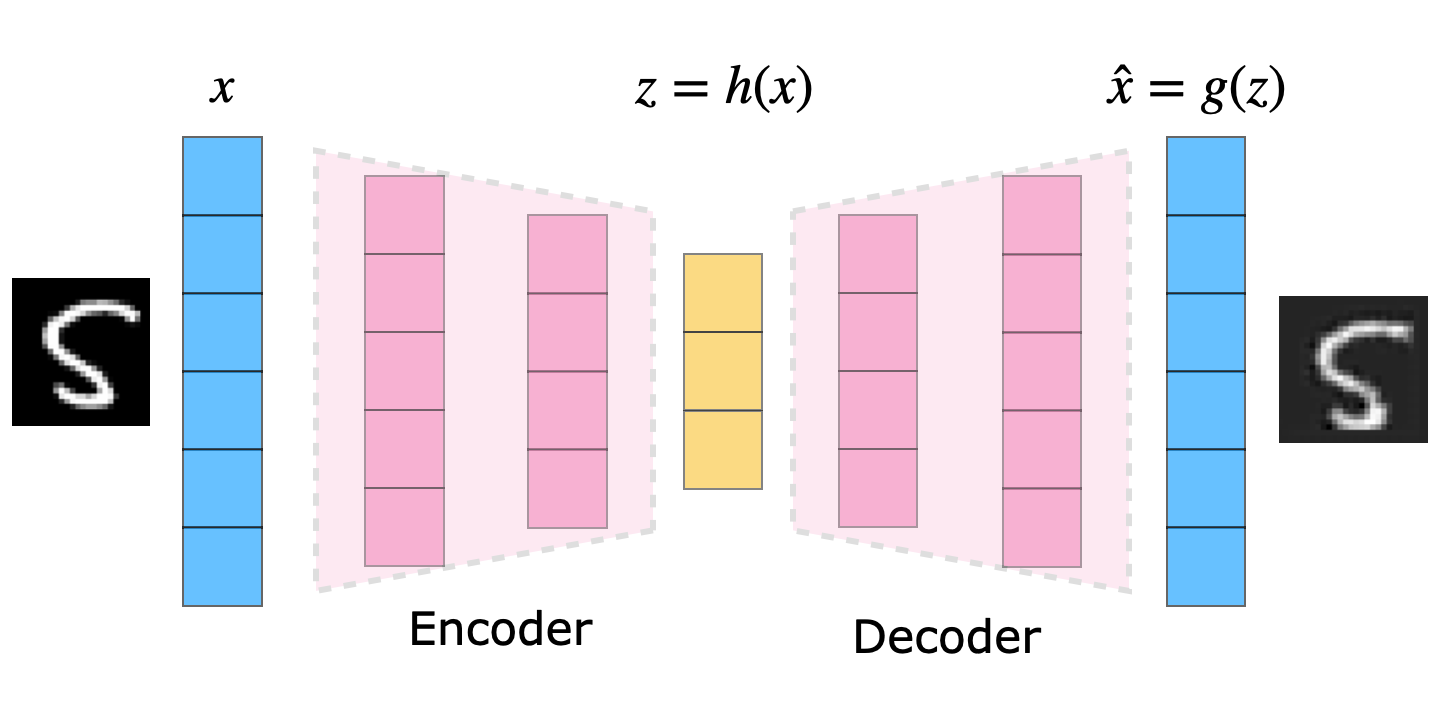
</div>


In [6]:
class GeneratorBlock(torch.nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.conv2d_trans = torch.nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, stride, padding, bias=False)
        self.batch_norm = torch.nn.BatchNorm2d(out_channels)
        self.activation = torch.nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))
    
class DiscriminatorBlock(torch.nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, stride=2,
                padding=1, alpha=0.2):
        super().__init__()
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = torch.nn.BatchNorm2d(out_channels)
        self.activation = torch.nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [7]:
class GeneratorModel(torch.nn.Module):
    def __init__(self, latent_dim=100, num_generator_channels=64):
        super().__init__()
        self.latent_dim = latent_dim
        n_G = num_generator_channels
        # (b, 100, 1, 1) -> (b, 64 * 8, 4, 4)
        self.block1 = GeneratorBlock(in_channels=100, out_channels=n_G*8, stride=1, padding=0)                  
        # (b, 64*8, 4, 4) -> (b, 64 * 4, 8, 8)
        self.block2 = GeneratorBlock(in_channels=n_G*8, out_channels=n_G*4)
        # (b, 64 * 4, 8, 8) -> (b, 64 * 2, 16, 16)
        self.block3 = GeneratorBlock(in_channels=n_G*4, out_channels=n_G*2)
        # (b, 64 * 2, 16, 16) -> (b, 64, 32, 32)
        self.block4 = GeneratorBlock(in_channels=n_G*2, out_channels=n_G)   
        # (b, 64, 32, 32) -> (b, 3, 64, 64)
        self.block5 = torch.nn.ConvTranspose2d(
            in_channels=n_G, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False
        )
        # Custom initialization
        with torch.no_grad():
            for w in self.parameters():
                # Normal with mean 0, std 0.02
                w.copy_(0.02 * torch.randn_like(w)) # in-place update
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        return torch.tanh(x)  # Output is always between 0 and 1

In [8]:
class DiscriminatorModel(torch.nn.Module):
    def __init__(self, num_discriminator_channels=64):
        super().__init__()
        n_D = num_discriminator_channels
        # (b, 3, 64, 64) -> (b, 64, 32, 32)
        self.block1 = DiscriminatorBlock(n_D)
        # (b, 64, 32, 32) -> (b, 64*2, 16, 16)
        self.block2 = DiscriminatorBlock(in_channels=n_D, out_channels=n_D*2)  # Output: (64 * 2, 16, 16)
        # (b, 64*2, 16, 16) -> (b, 64*4, 8, 8)
        self.block3 = DiscriminatorBlock(in_channels=n_D*2, out_channels=n_D*4)  # Output: (64 * 4, 8, 8)
        # (b, 64*4, 8, 8) -> (b, 64*8, 4, 4)
        self.block4 = DiscriminatorBlock(in_channels=n_D*4, out_channels=n_D*8)  
        # (b, 64*8, 4, 4) -> (b, 1, 1, 1)
        self.block5 = torch.nn.Conv2d(
            in_channels=n_D*8, out_channels=1, kernel_size=4, bias=False
        )  # Output is a real-valued score (pre-sigmoid)
        
        # Custom initialization
        with torch.no_grad():
            for w in self.parameters():
                # Normal with mean 0, std 0.02
                w.copy_(0.02 * torch.randn_like(w)) # in-place update
              
    def forward(self, x, return_feats=False):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        feats = x.view(x.shape[0], -1)  # (b, num_feats)
        x = self.block5(x).view(-1)  # (b,)
        if return_feats: # return features and score
            return feats, x
        else: # return only score
            return x 

In [9]:
generator = GeneratorModel()
discriminator = DiscriminatorModel()

print(f"Generator parameters =", sum([v.numel() for v in generator.parameters()]))
print(f"Discriminator parameters =", sum([v.numel() for v in discriminator.parameters()]))

Generator parameters = 3576704
Discriminator parameters = 2765696


# Generator and Discriminator Objectives

Let us now implement the objectives we discussed previously.

In [10]:
# Import binary classification version of `cross_entropy` function
from torch.nn.functional import binary_cross_entropy_with_logits 

def discriminator_objective(real_images, latent_z, generator, discriminator):
    # real_images: (b, 3, 64, 64) ; latent_z: (b, 100)
    # generator/discriminator: PyTorch Modules
    device = real_images.device
    batch_size = real_images.shape[0]
    # data to pass to loss: real and synthetic images
    syn_images = generator(latent_z).detach()  
    # Do not need grad w.r.t. generator in discriminator objective, so we detach it
    
    # Corresponding targets
    ones = torch.ones((batch_size,), device=device)  # for real images
    zeros = torch.zeros((batch_size,), device=device)  # for synthetic images
    
    # Predictions
    real_pred = discriminator(real_images) # (b,)
    syn_pred = discriminator(syn_images) # (b,)
    
    # Loss
    loss_1 = binary_cross_entropy_with_logits(real_pred, ones)  # classify real as 1
    loss_2 = binary_cross_entropy_with_logits(syn_pred, zeros)  # classify syn as 0
    return (loss_1 + loss_2) / 2
    
def generator_objective(latent_z, generator, discriminator):
    batch_size = latent_z.shape[0]
    # Data to pass to discriminator
    syn_images = generator(latent_z) # do not detach
    # Corresponding targets: recall that our goal here is to fool the disciminator
    ones = torch.ones((batch_size,), device=latent_z.device)
    # Disciminator predictions
    syn_pred = discriminator(syn_images)
    # loss
    return binary_cross_entropy_with_logits(syn_pred, ones)

## Logging

We track a notion of difference between the data distribution and model distribution, known as MAUVE. We will discuss these further in the lab. 

Install the package with `pip install mauve-text`.

**References**:

_MAUVE: Measuring the Gap Between Neural Text and Human Text using Divergence Frontiers._  
Krishna Pillutla, Swabha Swayamdipta, Rowan Zellers, John Thickstun, Sean Welleck, Yejin Choi, Zaid Harchaoui.  
NeurIPS 2021


_Divergence Frontiers for Generative Models: Sample Complexity, Quantization Level, and Frontier Integral._  
Lang Liu, Krishna Pillutla, Sean Welleck, Sewoong Oh, Yejin Choi, Zaid Harchaoui.  
NeurIPS 2021.

In [11]:
import mauve

@torch.no_grad()
def logging(generator, disciminator, dataloader, num_data=1024):
    device = next(generator.parameters()).device
    n = num_data // dataloader.batch_size
    real_data = []
    for i, (x, y) in enumerate(dataloader): 
        if i == n: # got enough real data
            break
        real_data.append(x)
    real_data = torch.cat(real_data, dim=0).to(device)

    latent_z = torch.normal(0, 1, size=(num_data, generator.latent_dim, 1, 1), device=device) # sample from R
    syn_data = generator(latent_z)

    # Featurize
    real_feats, real_score = discriminator(real_data, return_feats=True)
    syn_feats, syn_score = discriminator(syn_data, return_feats=True)

    # Compute gap using mauve
    gap = mauve.compute_mauve(
        p_features=real_feats.detach().cpu(), q_features=syn_feats.detach().cpu()
    ).frontier_integral
    
    # Compute accuracy of discriminator
    accuracy_of_discriminator = (
        ((real_score >= 0).sum() + (syn_score < 0).sum()) / 
        (real_score.shape[0] + syn_score.shape[0])
    )
    return gap, accuracy_of_discriminator.item()
    

In [12]:
from tqdm.auto import tqdm

def minibatch_sgd_onepass(generator, discriminator, dataloader, gen_optimizer, disc_optimizer):
    device = next(generator.parameters()).device  # device on which generator is stored (CPU/GPU)
    losses_gen = []
    losses_disc = []
    for real_images, _ in tqdm(dataloader):
        batch_size = real_images.shape[0]
        latent_z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1), device=device)  # sample from R
        real_images = real_images.to(device) # Move data to same device as models
        
        # Discriminator update
        discriminator.zero_grad()  # Zero out gradients from last update
        loss_disc = discriminator_objective(real_images, latent_z, generator, discriminator)
        loss_disc.backward()  # similar to torch.autograd.grad, but saved in w.grad for w in model.parameters()
        disc_optimizer.step()  # Perform SGD-like udpate
        losses_disc.append(loss_disc.item())  # for logging
        
        # Generator update
        generator.zero_grad()  # Zero out gradients from last update
        loss_gen = generator_objective(latent_z, generator, discriminator)
        loss_gen.backward()  # similar to torch.autograd.grad, but saved in w.grad for w in model.parameters()
        gen_optimizer.step()  # Perform SGD-like udpate
        losses_gen.append(loss_gen.item())  # for logging
    
    return np.mean(losses_disc), np.mean(losses_gen)

## Train
Now we train the GAN.

In [13]:
device = torch.device('cuda:0')  # Use GPU. For CPU say `torch.device('cpu')`

latent_dim, lr, num_epochs = 100, 0.005, 20  # Default params

# Setup models and move to device
generator = GeneratorModel(latent_dim).to(device)
discriminator = DiscriminatorModel().to(device)

# Setup optimizers
trainer_hp = {'lr': lr, 'betas': [0.5,0.999]}
disc_optimizer = torch.optim.Adam(discriminator.parameters(), **trainer_hp)
gen_optimizer = torch.optim.Adam(generator.parameters(), **trainer_hp)

logs = []

# Train!
for epoch in range(num_epochs): 
    t1 = time.time()
    loss_disc, loss_gen = minibatch_sgd_onepass(
        generator, discriminator, dataloader, gen_optimizer, disc_optimizer
    )
    t2 = time.time()
    gap, acc = logging(generator, discriminator, dataloader)
    t3 = time.time()
    logs.append((loss_disc, loss_gen, gap, acc))
    print(f"Epoch: {epoch+1}\tLoss_D: {loss_disc:.2f}\tLoss_G: {loss_gen:.2f}\tGap: {gap:.3f}\tAcc: {acc*100:.2f}",
         f"\tTime Train: {t2-t1:.2f}\t Time Log: {t3-t2:.2f}")
    


Epoch: 1	Loss_D: 0.64	Loss_G: 1.36	Gap: 0.612	Acc: 88.62 	Time Train: 51.91	 Time Log: 8.20



Epoch: 2	Loss_D: 0.53	Loss_G: 2.17	Gap: 0.508	Acc: 94.38 	Time Train: 68.09	 Time Log: 8.11



Epoch: 3	Loss_D: 0.47	Loss_G: 3.45	Gap: 0.953	Acc: 83.89 	Time Train: 52.28	 Time Log: 7.87



Epoch: 4	Loss_D: 0.40	Loss_G: 4.04	Gap: 0.441	Acc: 59.38 	Time Train: 52.24	 Time Log: 8.68



Epoch: 5	Loss_D: 0.48	Loss_G: 2.74	Gap: 0.399	Acc: 89.01 	Time Train: 52.56	 Time Log: 8.78



Epoch: 6	Loss_D: 0.41	Loss_G: 3.53	Gap: 0.412	Acc: 71.34 	Time Train: 69.20	 Time Log: 8.79



Epoch: 7	Loss_D: 0.31	Loss_G: 4.28	Gap: 0.250	Acc: 94.87 	Time Train: 52.93	 Time Log: 10.33



Epoch: 8	Loss_D: 0.25	Loss_G: 4.47	Gap: 0.323	Acc: 95.95 	Time Train: 75.25	 Time Log: 12.55



Epoch: 9	Loss_D: 0.19	Loss_G: 5.31	Gap: 0.232	Acc: 96.19 	Time Train: 53.07	 Time Log: 10.47



Epoch: 10	Loss_D: 0.14	Loss_G: 5.73	Gap: 0.159	Acc: 97.22 	Time Train: 54.49	 Time Log: 9.72



Epoch: 11	Loss_D: 0.20	Loss_G: 5.72	Gap: 0.140	Acc: 96.58 	Time Train: 52.80	 Time Log: 10.59



Epoch: 12	Loss_D: 0.08	Loss_G: 5.83	Gap: 0.130	Acc: 98.54 	Time Train: 52.95	 Time Log: 11.22



Epoch: 13	Loss_D: 0.10	Loss_G: 6.82	Gap: 0.127	Acc: 99.37 	Time Train: 58.87	 Time Log: 11.67



Epoch: 14	Loss_D: 0.13	Loss_G: 6.88	Gap: 0.146	Acc: 93.65 	Time Train: 71.25	 Time Log: 11.26



Epoch: 15	Loss_D: 0.06	Loss_G: 6.74	Gap: 0.150	Acc: 98.58 	Time Train: 56.85	 Time Log: 10.19



Epoch: 16	Loss_D: 0.04	Loss_G: 7.53	Gap: 0.122	Acc: 99.66 	Time Train: 53.36	 Time Log: 11.64



Epoch: 17	Loss_D: 0.08	Loss_G: 7.64	Gap: 0.123	Acc: 99.80 	Time Train: 55.07	 Time Log: 11.75



Epoch: 18	Loss_D: 0.03	Loss_G: 8.06	Gap: 0.112	Acc: 99.85 	Time Train: 52.91	 Time Log: 10.79



Epoch: 19	Loss_D: 0.25	Loss_G: 7.41	Gap: 0.111	Acc: 86.72 	Time Train: 52.72	 Time Log: 10.37



Epoch: 20	Loss_D: 0.10	Loss_G: 6.25	Gap: 0.127	Acc: 97.17 	Time Train: 52.80	 Time Log: 11.06


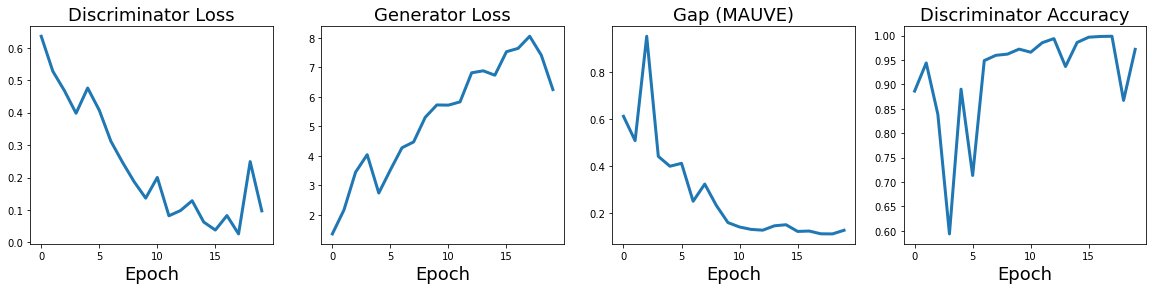

In [15]:
logs2 = np.asarray(logs)

f, ax = plt.subplots(1, 4, figsize=(20, 4))

titles = ["Discriminator Loss", "Generator Loss", "Gap (MAUVE)", "Discriminator Accuracy"]
for i in range(4):
    ax[i].plot(logs2[:,i], lw=3)
    ax[i].set_xlabel('Epoch', fontsize=18)
    ax[i].set_title(titles[i], fontsize=18)
    

# Inspect Samples

In [16]:
def sample_images(generator, n=10):
    latent_dim = generator.latent_dim
    device = next(generator.parameters()).device
    # Show generated examples
    latent_z = torch.normal(0, 1, size=(n, latent_dim, 1, 1), device=device)
    # Normalize the synthetic data to N(0, 1)
    imgs = generator(latent_z) / 2 + 0.5  # Undo normalization
    imgs = imgs.detach().cpu().numpy()  # (N, C, H, W)
    f, ax = plt.subplots(2, n//2, figsize=(2*n, 10))
    ax = ax.flatten()
    for i in range(n):
        ax[i].imshow(imgs[i].transpose(1, 2, 0))

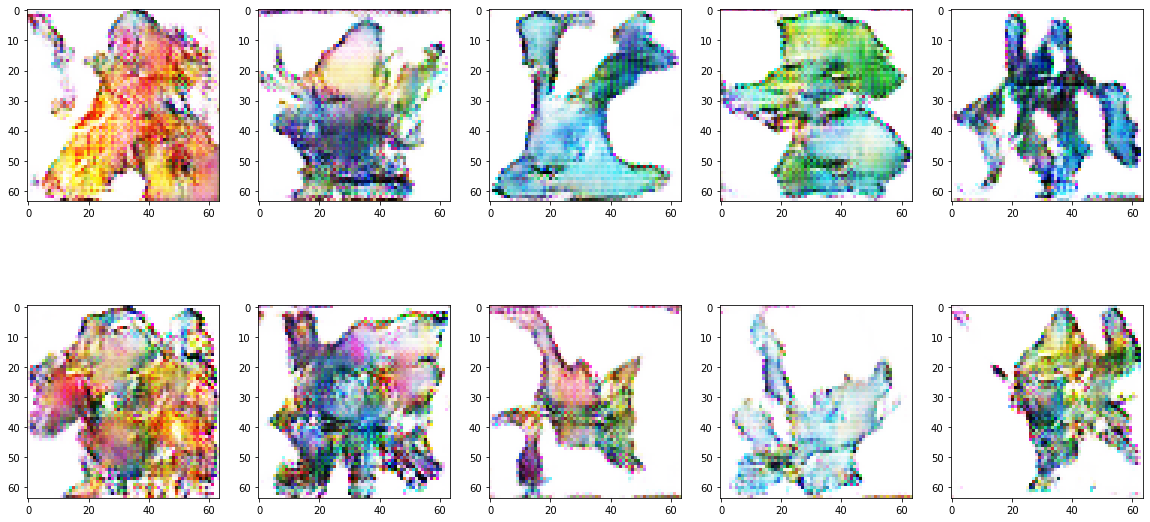

In [19]:
sample_images(generator)

# Interpolating Between Images

In [18]:
def interpolate_images(generator, n=16):
    latent_dim = generator.latent_dim
    device = next(generator.parameters()).device
    # Show generated examples
    z1 = torch.normal(0, 1, size=(latent_dim, 1, 1), device=device)
    z2 = torch.normal(0, 1, size=(latent_dim, 1, 1), device=device)
    interpolations = torch.stack([z1 + t * (z2 - z1) for t in np.linspace(0, 1, n)])
    
    # Normalize the synthetic data to N(0, 1)
    imgs = generator(interpolations) / 2 + 0.5  # Undo normalization
    imgs = imgs.detach().cpu().numpy()  # (N, C, H, W)
    f, ax = plt.subplots(2, n//2, figsize=(2*n, 10))
    ax = ax.flatten()
    for i in range(n):
        ax[i].imshow(imgs[i].transpose(1, 2, 0))

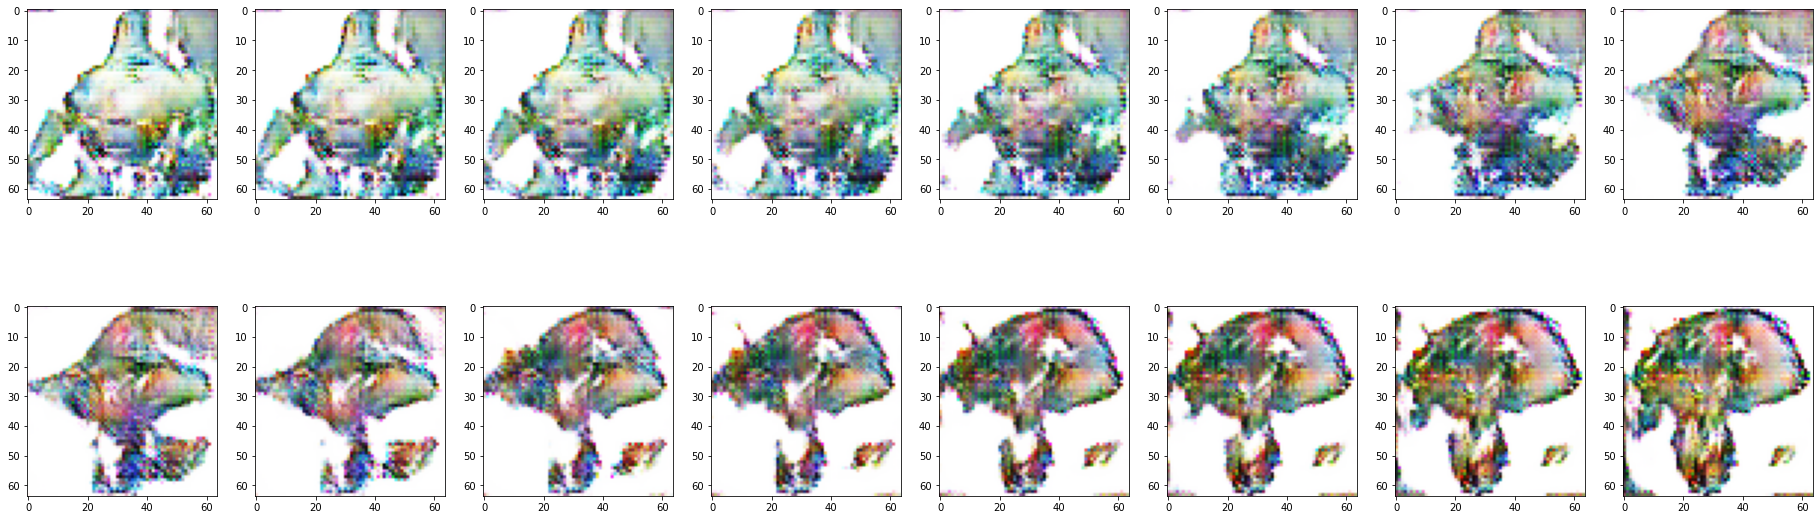

In [23]:
interpolate_images(generator)